In [109]:
#!pip install -q imdb-sqlite
#!pip install -q pycountry

In [110]:
# imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [111]:
%%time
!imdb-sqlite

Wall time: 267 ms


2022-04-21 10:36:20,429 DB already exists: (imdb.db). Refusing to modify. Exiting


Carregamento dos Dados

In [112]:
connection = sqlite3.connect("imdb.db")

In [113]:
tables = pd.read_sql_query("select name as 'Table_Name' from sqlite_master where type = 'table'", connection)
tables = tables["Table_Name"].values.tolist()

In [114]:
for table in tables:
    query = "PRAGMA TABLE_INFO({})".format(table)
    result = pd.read_sql_query(query, connection)
    print("Esquema da tabela:", table)
    display(result)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




1 - Quais são as categorias de filmes mais comuns no IMDB?

In [115]:
query1 = '''select type, count(*) as count from titles group by type order by 2 desc'''
result1 = pd.read_sql_query(query1, connection)
display("result1:", result1)

'result1:'

,type,count
0,tvEpisode,6651598
1,short,865592
2,movie,607710
3,video,259395
4,tvSeries,223734
5,tvMovie,135795
6,tvMiniSeries,43068
7,tvSpecial,36603
8,videoGame,30921
9,tvShort,10524


In [116]:
result1['percent'] = (result1['count'] / result1['count'].sum()) * 100
display(result1)

,type,count,percent
0,tvEpisode,6651598,75.032617
1,short,865592,9.764215
2,movie,607710,6.855206
3,video,259395,2.926077
4,tvSeries,223734,2.523807
5,tvMovie,135795,1.531821
6,tvMiniSeries,43068,0.485824
7,tvSpecial,36603,0.412896
8,videoGame,30921,0.348801
9,tvShort,10524,0.118715


In [117]:
others = {}
others['count'] = result1[result1['percent'] < 6]['count'].sum()
others['percent'] = result1[result1['percent'] < 6]['percent'].sum()
others['type'] = 'others'
print('others:', others)

others: {'count': 740042, 'percent': 8.347962118646686, 'type': 'others'}


In [118]:
result1 = result1[result1['percent'] >= 6]
result1 = result1.append(others, ignore_index=True)
result1 = result1.sort_values(by='percent', ascending=False)
display(result1)

,type,count,percent
0,tvEpisode,6651598,75.032617
1,short,865592,9.764215
3,others,740042,8.347962
2,movie,607710,6.855206


In [119]:
#Ajustar labels
labels = [str(result1['type'][i]).capitalize()+' ['+str(round(result1['percent'][i], 2))+'%]' for i in result1.index]
labels

['Tvepisode [75.03%]', 'Short [9.76%]', 'Others [8.35%]', 'Movie [6.86%]']

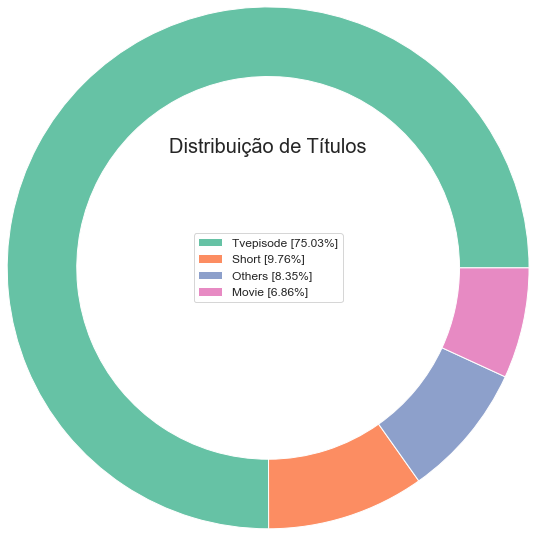

In [120]:
cs = cm.Set2(np.arange(100))
f = plt.figure()

plt.pie(result1['count'], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc='center', prop={'size':12})
plt.title("Distribuição de Títulos", loc='Center', fontdict={'fontsize':20, 'fontweight':20})
plt.show()

2 - Qual o número de títulos por gênero?

In [121]:
query2 = '''SELECT genres, COUNT(*) as count FROM titles WHERE type = 'movie' GROUP BY 1'''
result2 = pd.read_sql_query(query2, connection)

In [122]:
display(result2)

,genres,count
0,Action,13973
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1454,"Thriller,Western",43
1455,War,1293
1456,"War,Western",14
1457,Western,5153


In [123]:
result2['genres'] = result2['genres'].str.lower().values
temp = result2['genres'].dropna()

In [124]:
pattern = '(?u)\\b[\\w-]+\\b'
vector = CountVectorizer(token_pattern=pattern, analyzer='word').fit(temp)
vector

CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b')

In [125]:
bag_genres = vector.transform(temp)
unique_genres = vector.get_feature_names()
genres = pd.DataFrame(bag_genres.todense(), columns=unique_genres, index=temp.index)
genres = genres.drop(columns='n', axis=0)
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1459 non-null   int64
 1   adult        1459 non-null   int64
 2   adventure    1459 non-null   int64
 3   animation    1459 non-null   int64
 4   biography    1459 non-null   int64
 5   comedy       1459 non-null   int64
 6   crime        1459 non-null   int64
 7   documentary  1459 non-null   int64
 8   drama        1459 non-null   int64
 9   family       1459 non-null   int64
 10  fantasy      1459 non-null   int64
 11  film-noir    1459 non-null   int64
 12  game-show    1459 non-null   int64
 13  history      1459 non-null   int64
 14  horror       1459 non-null   int64
 15  music        1459 non-null   int64
 16  musical      1459 non-null   int64
 17  mystery      1459 non-null   int64
 18  news         1459 non-null   int64
 19  reality-tv   1459 non-null   int64
 20  romance 

In [126]:
genres_percent = 100 * pd.Series(genres.sum()).sort_values(ascending=False) / genres.shape[0]
genres_percent.head(10)

drama          18.094585
comedy         16.792324
documentary    15.764222
adventure      14.804661
action         14.461960
romance        13.296779
crime          13.159698
mystery        12.542838
thriller       12.268677
fantasy        12.131597
dtype: float64

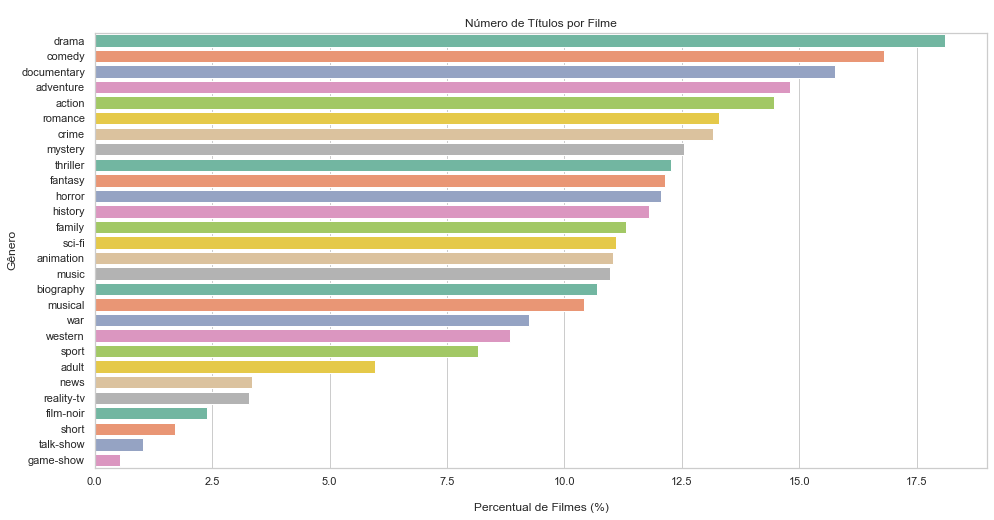

In [127]:
plt.figure(figsize=(16,8))
sns.barplot(x=genres_percent, y=genres_percent.index, orient='h', palette='Set2')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)')
plt.title('\nNúmero de Títulos por Filme')
plt.show()